In [20]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_scratch
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve,auc  
from sklearn.model_selection import KFold

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Dataset
# read csv data
df= pd.read_csv(r'P:\challange platinum\dataset_platinum\train_preprocess.tsv.txt', sep='\t',names=['data','label'],encoding='latin-1')
df = df.drop_duplicates()
df_alay = pd.read_csv(r'P:\challange platinum\dataset_platinum\new_kamusalay.csv', names=['alay','cleaned'],encoding='latin-1')

In [22]:
df.isna()


,data,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
10993,False,False
10994,False,False
10996,False,False
10998,False,False


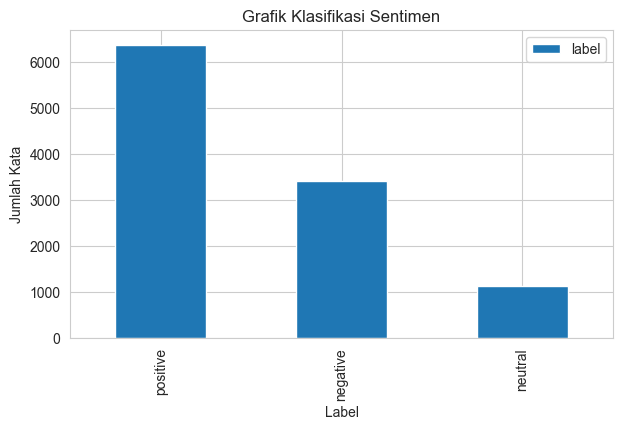

In [23]:
# Chart Klasifikasi Sentimen
df["label"].value_counts().plot.bar(figsize = (7, 4))
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [24]:
# Data Mapping
mapping = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}

df['kategori_label'] = df['label'].replace(mapping)
df['ln_text'] = df['data'].str.len()
df.head()

,data,label,kategori_label,ln_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,2,404
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,1,102
2,lokasi strategis di jalan sumatera bandung . t...,positive,2,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,2,93
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,0,214


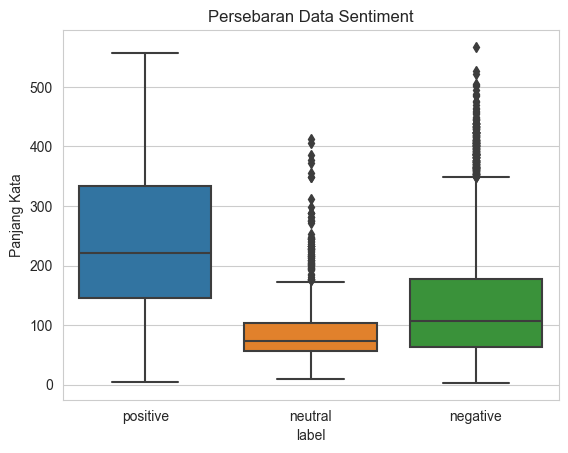

In [25]:
# Box plot
sns.set_style('whitegrid')
sns.boxplot(y = df['ln_text'] , x = df['label']);
plt.ylabel('Panjang Kata')
plt.title('Persebaran Data Sentiment')
plt.show()

In [26]:
# Data Information
print(df['kategori_label'].describe(include=["all"]))

count    10933.000000
mean         1.271746
std          0.906720
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: kategori_label, dtype: float64


In [27]:
# Count Label
jumlah_data_per_label = df['label'].value_counts()
jumlah_data_per_label

positive    6383
negative    3412
neutral     1138
Name: label, dtype: int64

In [28]:
# Stopwords
list_stopwords = stopwords_scratch.words('indonesian')
list_stopwords_en = stopwords_scratch.words('english')
list_stopwords.extend(list_stopwords_en)
list_stopwords.extend(['ya','yg','ga','yuk','dah','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'])

# External Stopwords
f = open("P:\challange platinum\dataset_platinum\stopwords.txt", "r")
stopword_external = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_external.append(line_list[0])
f.close()
list_stopwords.extend(stopword_external)

stopwords = list_stopwords

len(stopwords)

1002

In [30]:
# Cleansing Data
def lowercase(text): # Change uppercase characters to lowercase
    return text.lower()

def special(text): # Remove all the special characters
    text = re.sub(r'\W', ' ',str(text), flags=re.MULTILINE)
    return text

def single(text): # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def singlestart(text): # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def mulspace(text): # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text

def rt(text): # Remove RT
    text = re.sub(r'rt @\w+: ', ' ', text, flags=re.MULTILINE)
    return text

def prefixedb(text): # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text, flags=re.MULTILINE)
    return text

def misc(text): # Remove URL, Mention, Hashtag, user, Line, and Tab
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', text, flags=re.MULTILINE)
    return text

alay_mapping = dict(zip(df_alay['alay'], df_alay['cleaned'])) # Mapping for kamusalay
def alay(text): # Remove by replacing 'alay' words
    wordlist = text.split()
    text_alay = [alay_mapping.get(x,x) for x in wordlist]
    clean_alay = ' '.join(text_alay)
    return clean_alay

def stopwrds(text): # Stopwords fuction
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    output_sw = ' '.join(tokens_without_sw)
    return output_sw

#Function for text cleansing
def cleaning(text):
    text = lowercase(text)
    text = special(text)
    text = single(text)
    text = singlestart(text)
    text = mulspace(text)
    text = rt(text)
    text = prefixedb(text)
    text = misc(text)
    text = alay(text)
    # text = stopwrds(text)
    return text

In [31]:
def stemming(text):
    word_token = word_tokenize(text)
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    input_stemm = str(word_token)
    output_stemm = stemmer.stem(input_stemm)
    stemmed_text = ' '.join(output_stemm)
    return stemmed_text

In [32]:
clean_text = df['data'].apply(lambda x: cleaning(x))
clean_text

0        warung ini dimiliki oleh pengusaha pabrik tahu...
1        mohon ulama lurus dan k212 mmbri hujjah partai...
2        lokasi strategis di jalan sumatra bandung temp...
3        betapa bahagia nya diri ini saat unboxing pake...
4        aduh jadi mahasiswa jangan sombong dong kasih ...
                               ...                        
10993    f demokrat dorong upaya kemandirian energi nas...
10994                                          tidak bosan
10996    enak rasa masakan nya apalagi kepiting yang me...
10998    pagi pagi di tol pasteur sudah macet parah bik...
10999    meskipun sering belanja ke yogyakarta di riau ...
Name: data, Length: 10933, dtype: object

In [56]:
texts = df.iloc[:,0].values
data = []
for sentence in range(0, len(texts)):
    texts_clean = cleaning(str(texts[sentence]))
    #texts_stem = stemming(texts_clean)
    data.append(texts_clean)

df.text = data

labels = df.iloc[:,1]

df.to_csv(r"P:\challange platinum\dataset_platinum\train_preprocess.tsv.txt")

In [57]:
df.head()

,data,label,kategori_label,ln_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,2,404
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,1,102
2,lokasi strategis di jalan sumatera bandung . t...,positive,2,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,2,93
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,0,214


In [58]:
def hyperparam_tuning(xtrain, xtest, ytrain, ytest, classifier, param_grid):
    # split ytrain to create cross validation
    ytrain_split, ytest_split = train_test_split(ytrain, test_size=0.6, random_state=0)

    # create predefined split
    # -1 for all training and 0 for all test
    ps = PredefinedSplit([-1] * ytrain_split.shape[0] + [0] * ytest_split.shape[0])
    clf = GridSearchCV(classifier, param_grid, n_jobs=-1, cv=ps)
    clf = clf.fit(xtrain,ytrain)
    return clf

def train_and_test(feature="bow", classifier="nb"):
    xtrain, xtest, ytrain, ytest = train_test_split(data,labels,test_size=0.2, random_state=0)
    # train feature on train data
    if feature == "bow":
        vectorizer = CountVectorizer()
    elif feature == "tfidf":
        vectorizer = TfidfVectorizer()
    else:
        raise Exception('Vectorizer unknown. Use "BoW" or "tfidf"')
    vectorizer.fit(xtrain)

    # transform
    xtrain = vectorizer.transform(xtrain)
    xtest = vectorizer.transform(xtest)
    
    # all classifiers
    classifier_model = {"nb" : MultinomialNB(),
                        "svm": SVC(),
                        "lr" : LogisticRegression(max_iter=1000),
                        "mlp": MLPClassifier() 
                       }
    # all params for grid-search
    param_grids = {"nb" : {"alpha": np.linspace(0.001,1,50)},
                   "svm": {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']},
                   "lr" : {'C': np.linspace(0.001,10,100)},
                   "mlp": {'activation': ['relu']}
                  }
    
    # hyperparam_tuning used for model besides MLP, since MLP works better without hyperparamater
    #clf = hyperparam_tuning(xtrain, xtest, ytrain, ytest, classifier=classifier_model[classifier], param_grid=param_grids[classifier])

    model = MLPClassifier()
    clf = model.fit(xtrain, ytrain)

    pred = clf.predict(xtest.toarray())
    f1 = f1_score(ytest,pred, average='micro')
    
    return f1, clf, vectorizer, pred, xtrain, xtest, ytrain, ytest

In [59]:
input_sentiment = "bangsat"

print(f"Training for sentiment analysis classifier")
f1, clf, vectorizer, pred, xtrain, xtest, ytrain, ytest = train_and_test(feature="tfidf", classifier="mlp")
print(f"Training done. F1 on test set is {f1}")

input_sentiment = " ".join(word_tokenize(input_sentiment))
sent = clf.predict(vectorizer.transform([input_sentiment]).toarray())
print(f"\nSentiment on the input text is {sent}")

Training for sentiment analysis classifier
Training done. F1 on test set is 0.850480109739369

Sentiment on the input text is ['negative']


In [60]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

    negative       0.78      0.82      0.80       689
     neutral       0.82      0.71      0.76       236
    positive       0.89      0.90      0.89      1262

    accuracy                           0.85      2187
   macro avg       0.83      0.81      0.82      2187
weighted avg       0.85      0.85      0.85      2187



In [62]:
import joblib

joblib.dump(f1,'score.pkl')
joblib.dump(clf,'model.pkl')
joblib.dump(vectorizer,'vectorizer.pkl')

['vectorizer.pkl']

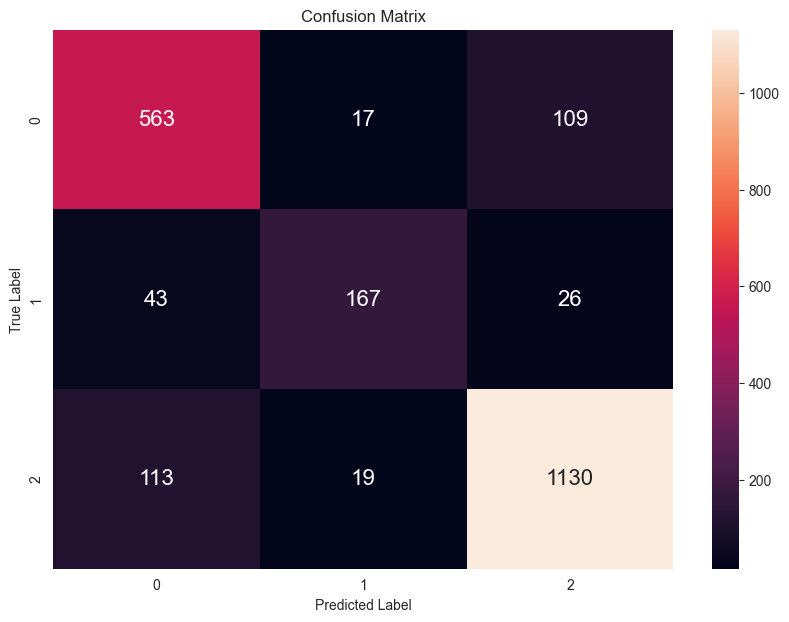

In [63]:
def plot_confusion_matrix(ytest, pred):  
     conf_mat = pd.DataFrame(confusion_matrix(ytest, pred))  
     fig = plt.figure(figsize=(10, 7))  
     sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt="g")  
     plt.title("Confusion Matrix")  
     plt.xlabel("Predicted Label")  
     plt.ylabel("True Label")  
     plt.show()
   
plot_confusion_matrix(ytest,pred)

In [65]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

vectorizer.fit(df.iloc[:,0])
x = vectorizer.transform(df.iloc[:,0])
y = labels.values

for iteration, datas in enumerate(kf.split(x), start=1):
  data_train = x[datas[0]]
  target_train = y[datas[0]]

  data_test = x[datas[1]]
  target_test = y[datas[1]]

  clf = MLPClassifier()
  clf.fit(data_train,target_train)

  preds = clf.predict(data_test)

  accuracy = accuracy_score(target_test,preds)

  print('Training no: ', iteration)
  print(classification_report(target_test,preds))
  print('=================================================================')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Average Accuracy: ', average_accuracy)

Training no:  1
              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       690
     neutral       0.80      0.75      0.78       220
    positive       0.89      0.91      0.90      1277

    accuracy                           0.86      2187
   macro avg       0.83      0.82      0.83      2187
weighted avg       0.86      0.86      0.86      2187

Training no:  2
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79       667
     neutral       0.81      0.70      0.75       219
    positive       0.89      0.90      0.89      1301

    accuracy                           0.85      2187
   macro avg       0.83      0.80      0.81      2187
weighted avg       0.85      0.85      0.85      2187

Training no:  3
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       695
     neutral       0.81      0.75      0.78       213
    positive       0.88    